**Diplomatura en Ciencia de Datos, Aprendizaje Automático y sus Aplicaciones**

**Edición 2022**

## **Mentoría: Data Science aplicado a BCI**

---
## **Trabajo Práctico 1**
## Análisis y Visualización
---

## **Grupo 2**

**Integrantes:** Gastón Briozzo, Pablo Ventura

**Profesor de Práctico:** Juan Manuel Lopez

# Importación de librerias

In [ ]:
import io
import matplotlib
import matplotlib.pyplot as plt
import seaborn
import itertools
import os
import numpy as np
import pandas as pd
import scipy
#import pyforest
import pathlib
from csv import reader
from scipy import signal
from scipy.signal import spectrogram
from pathlib import Path

#seaborn.set_context('talk')

In [ ]:
!git clone https://github.com/pablogventura/bci_2.git
!mv bci_2/Database/* .
!mv "JA 1 - 2020 - 11-19.txt" "JA 1 - 2020-11-19.txt"

Clonando en 'bci_2'...
remote: Enumerating objects: 10, done.
remote: Counting objects: 100% (10/10), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 10 (delta 0), reused 10 (delta 0), pack-reused 0
Desempaquetando objetos: 100% (10/10), 12.03 MiB | 6.51 MiB/s, listo.


# Parte I: Exploración de la base de datos.

## I A) Leer los datos, eliminar los metadatos innecesarios.

Demos un primer vistazo a los conjuntos de datos. Para esto, serán sumamente provechosas las funciones definidas en codigo_notebooks/utils.py, las cuales copiamos a continuación:

In [ ]:
# Útil

def has_metadata(csv_path):
    f = open(csv_path, newline='')
    csv_reader = reader(f)
    return True if next(csv_reader)[0] == '%OpenBCI Raw EEG Data' else False


def raw_read_bci_csv(csv_path):
    csv_reader = reader(open(csv_path, newline=''))
    n_lines = 10 if next(csv_reader)[0] == '%OpenBCI Raw EEG Data' else 0
    column_names = [
        'sample_index', 'ch0', 'ch1', 'ch2', 'ch3', 'acc0',
        'acc1', 'acc2', 'label', 'provided_time', 'timestamp'
    ]
    dataset = pd.read_csv(csv_path, skiprows=n_lines, index_col=False, names=column_names)
    sample_rate = 200.
    dataset['time'] = dataset.index.values/sample_rate
    return dataset


def clean_read_bci_csv(csv_path):
    dataset = raw_read_bci_csv(csv_path)
    dataset.drop(columns=['sample_index', 'acc0', 'acc1', 'acc2', 'provided_time', 'timestamp'], inplace=True)
    return dataset


def add_sub_label(dataset):
    labels = dataset.label.unique().tolist()
    for label in labels:
        sample_idx = dataset.loc[dataset.label == label].index.values
        gap_btn_idx = sample_idx[1:] - sample_idx[:-1]
        selected_idx = np.insert((gap_btn_idx != 1), 0, True)
        desired_idx_bottom = sample_idx[selected_idx]
        selected_idx = np.append(selected_idx[1:], True)
        desired_idx_top = sample_idx[selected_idx]
        for k, (start, stop) in enumerate(zip(desired_idx_bottom, desired_idx_top)):
            selection = (dataset.index.values >= start) & (dataset.index.values <= stop)
            dataset.loc[selection, 'sub_label'] = f'{label}-{k}'
    return dataset


def detrend_channels(dataset, mode='both', window=200):
    if mode in ['global', 'both']:
        detrend_global = dataset.copy()
    if mode in ['both', 'local']:
        detrend_local = dataset.copy()
    for subject in dataset.subject.unique():
        selection = (dataset.subject == subject)
        for session in dataset.loc[selection, 'session'].unique():
            selection2 = selection & (dataset.session == session)
            if mode in ['global', 'both']:
                for ch in ['ch0', 'ch1', 'ch2', 'ch3']:
                    y = dataset.loc[selection2, ch].values
                    detrend_global.loc[selection2, ch] = signal.detrend(y)
            if mode in ['both', 'local']:
                for ch in ['ch0', 'ch1', 'ch2', 'ch3']:
                    index = dataset.loc[selection2].index.tolist()
                    iters = [iter(index)] * window
                    for k, index_set in enumerate(itertools.zip_longest(*iters)):
                        if None in index_set:
                            index_set = list(filter(None, index_set))
                        selection3 = selection2 & dataset.index.isin(index_set)
                        y = dataset.loc[selection3, ch].values
                        detrend_local.loc[selection3, ch] = signal.detrend(y)
    if mode == 'global':
        return detrend_global
    if mode == 'local':
        return detrend_local
    else:
        return detrend_global, detrend_local


def read_all_datasets(csvs_path: Path):
    complete_dataset = pd.DataFrame()
    for csv_path in csvs_path.iterdir():
        dataset = clean_read_bci_csv(csv_path)
        dataset = add_sub_label(dataset)
        dataset['subject'] = csv_path.name[:2]
        dataset['session'] = csv_path.name[3]
        dataset['sub_sess'] = dataset.subject + '-' + dataset.session
        complete_dataset = pd.concat([complete_dataset, dataset])
    return complete_dataset

Notemos que estas funciones eliminan automaticamente los metadatos y las columnas irrelevantes de los archivos, por lo que dicho trabajo ya está completo.

Veamos que aspecto tienen los dataframe resultantes

In [ ]:
df_AA0 = clean_read_bci_csv('AA 0 - 2020-10-28.csv')
df_AA1 = clean_read_bci_csv('AA 1 - 2020-11-24.txt')
df_AA2 = clean_read_bci_csv('AA 2 - 2020-11-24.txt')
df_HA1 = clean_read_bci_csv('HA 1 - 2020-11-24.txt')
df_JA1 = clean_read_bci_csv('JA 1 - 2020-11-19.txt')
df_JA2 = clean_read_bci_csv('JA 2 - 2020-11-24.txt')
df_MA1 = clean_read_bci_csv('MA 1 - 2020-12-18.txt')

df_AA0

,ch0,ch1,ch2,ch3,label,time
0,-1.86,-12.95,-9.18,-41.36,99,0.000
1,10.77,3.47,6.87,-15.13,99,0.005
2,87.61,65.61,88.78,32.23,99,0.010
3,83.04,50.88,77.30,4.49,99,0.015
4,8.07,-20.55,-6.68,-38.09,99,0.020
...,...,...,...,...,...,...
45968,-15.69,-22.97,3.24,-75.01,99,229.840
45969,84.95,73.30,116.55,-5.97,99,229.845
45970,73.14,47.58,95.13,-36.34,99,229.850
45971,3.68,-20.26,13.70,-89.01,99,229.855


Vemos que, efectivamente, los metadatos han sido eliminados. Comentemos, sin embargo, cuales eran estos.

Cada archivo .txt comienza con una breve introducción que ocupa las primeras 10 filas de texto, donde se describen los datos propiamente dichos. 

%OpenBCI Raw EEG Data
%Number of channels = 4
%Sample Rate = 200.0 Hz
%First Column = SampleIndex
%Last Column = Timestamp 
%Second to last column = stimulus/prediction tags
%TAG CODE:
%During calibration: 0 --> not looking; 1 --> looking left; 2 --> looking right, 99 --> NaN (default value)
%During prediction (idem calibration + 10): 10 --> not looking; 11 --> looking left; 12 --> looking right
%Other Columns = EEG data in microvolts followed by Accel Data (in G) interleaved with Aux Data

Al encontrarse con esta introducción, pandas no sabe como interpretar los datos, por lo que es recomendable eliminarla. Esto es lo que se hace en la función raw_read_bci_csv.

Los datos son ahora legibles. Se han eliminado los metadatos innecesarios (primeras 10 filas). 

## I B) Describir las características generales del dataset:

### I B) 1. Número de registros, diferencias entre los mismos.

El conjunto de datos consta de un total de 7 registros, correspondientes a 4 sujetos en hasta 3 sesiones cada uno. Las diferencias entre estos dependerán tanto de la realización de cada estudio como de las particularidades de cada sujeto y sus circunstancias durante la sesión.

Una mejor descripción de las diferencias entre los registros podrá darse una vez su análisis sea completado.

In [ ]:
estadisticas = pd.DataFrame()
esta = df_AA0.describe().round()
#estadisticas['AA0'] = df_AA0.describe().round()
#estadisticas['AA1'] = df_AA1.describe().round()
#estadisticas['AA2'] = df_AA2.describe().round()
#estadisticas['HA1'] = df_HA1.describe().round()
#estadisticas['JA1'] = df_JA1.describe().round()
#estadisticas['JA2'] = df_JA2.describe().round()
#estadisticas['MA1'] = df_MA1.describe().round()

esta

,ch0,ch1,ch2,ch3,label,time
count,45973.0,45973.0,45973.0,45973.0,45973.0,45973.0
mean,43.0,26.0,51.0,-27.0,37.0,115.0
std,48.0,45.0,52.0,39.0,47.0,66.0
min,-68.0,-81.0,-70.0,-163.0,1.0,0.0
25%,-2.0,-17.0,2.0,-60.0,1.0,57.0
50%,42.0,25.0,50.0,-26.0,2.0,115.0
75%,88.0,68.0,100.0,6.0,99.0,172.0
max,186.0,168.0,195.0,101.0,99.0,230.0


### I B) 2. Definir la conveniencia de trabajar todos juntos como un solo dataset, o por separado.

Dado que los distintos registros corresponden a diferentes sujetos, no sería correcto agrupar los datos indiscriminadamente. Por un lado, la cantidad de registros no es tan alta como para que sea complicado manipularlos de forma diferenciada. Por el otro, tratar los casos por separado nos podría permitir distinguir comportamientos característicos en un individuo, o patrones que se pasarían desapercibidos de otro modo.

Por estas razones, consideramos conveniente trabajar con cada registro por separado.

## I C) Analizar las columnas presentes en el dataset:

### I C) 1. ¿Todas las columnas son relevantes? ¿Cuáles contienen información útil?

Los registros cuentan con un total de 11 columnas, las cuales se corresponden a 


1. Número de Muestra
2. Canal 1
3. Canal 2
4. Canal 3
5. Canal 4
6. Acelerómetro x
7. Acelerómetro y
8. Acelerómetro z
9. Etiqueta
10. Tiempo
11. Timestamps

Si bien el número de la muestra puede parecer importante para identificarla, la verdad es que esto puede hacerse atendiendo al tiempo de la medición, por lo que esta columna no es relevante. 

Las 4 columnas Canal nos dan la diferencia de potencial medida en microvoltios por cada electrodo, siendo esta la información que intentaremos modelar, por lo que estas columnas son relevantes. 

Las 3 columnas del Acelerómetro no registran información ya que no se emplearon durante la recolección de datos, por lo que resultan irrelevantes.

La columna Etiqueta indica el estímulo percibido por el sujeto en los instantes correspondientes de la recolección de datos, siendo justamente la variable que buscaremos predecir en el futuro, por lo que esta columna resulta relevante. 

La columna Tiempo registra la evolución temporal de los estímulos y las respuestas de los sujetos, resultando de gran utilidad para identificar los datos, por lo que esta columna resulta relevante. Sin embargo, es posible que sea conveniente renormalizar los tiempos para que estos valores resulten mas portables.

La columna Timestamps da exactamente la misma información que la columna Tiempo, solo que en fotmato de maquina, por lo que esta columna resulta irrelevante.

De esta forma, las columnas relevantes son

1. Canal 1
2. Canal 2
3. Canal 3
4. Canal 4
5. Etiqueta
6. Tiempo

### I C) 2. ¿Qué tipo de datos contienen? ¿Qué variables describen las columnas consideradas? ¿Con qué sensibilidad?

In [ ]:
df_AA0.describe()

,ch0,ch1,ch2,ch3,label,time
count,45973.000000,45973.000000,45973.000000,45973.000000,45973.000000,45973.000000
mean,42.909730,25.580902,50.757091,-27.097523,36.546342,114.930000
std,48.323405,45.253793,51.727307,38.634887,46.786582,66.357031
min,-68.080000,-81.200000,-69.520000,-163.350000,1.000000,0.000000
25%,-2.340000,-16.880000,1.800000,-60.500000,1.000000,57.465000
50%,42.050000,25.450000,50.080000,-26.410000,2.000000,114.930000
75%,88.170000,67.940000,99.970000,5.840000,99.000000,172.395000
max,185.650000,167.980000,195.350000,100.820000,99.000000,229.860000


Todos los datos son de punto fotante salvo el label que es entero. La sensibilidad de los canales es 0.01 µV y del tiempo es 0.005 s y como el label es una variable categorica no tiene sentido hablar de sensibilidad. 

Los cuatro canales describen potencial en µV, "time" describe el tiempo de la muestra relativo al inicio de la sesion en segundos mientras que la columna "label" es categorica y describe el estimulo percibido por el sujeto, donde 1 se corresponde al estimulo de frecuencia 12.5Hz, al estimulo de frecuencia 16.5Hz y 99 a la ausencia de estimulo.

### I C) 4. Para todas las columnas, ¿hay datos dañados? ¿valores nulos? ¿Qué estrategia considera más pertinente para abordar esos datos? Justifique.

La unica irregularidad es la que tenian originalmente los datos en el tiempo debido a inconsistencias en la frecuencia de muestreo registrada. Sin embargo el proveedor nos asegura que la frecuencia de muestreo del aparato es de 200Hz por lo que recalculamos la columna "time" para que cumpla con esa especificacion. No se encontraron otras irregularidades.

### I C) 5. Suponiendo que los datos se adquieren a una frecuencia de muestreo exacta 200Hz, ¿cómo se manifiesta esta información en el número de muestras presentes en el registro?

La duracion de la sesion puede calcularse tomando el numero de datos que contiene y diviviendolo por 200 para conseguir el tiempo en segundos.

### I C) 6. Determine la forma más adecuada de parsear los datos temporales para poder graficar las señales en el dominio del tiempo.

Los datos fueron convertidos a un intervalo de tiempo relativo al inicio de la sesion aumentando cada muestra en 0.005s.

## I D) Generar visualizaciones de ejemplo para las series temporales provistas. Determinar los intervalos de tiempo más adecuados para generar visualizaciones claras que permitan comparar las señales en los siguientes escenarios:

### I D) 1. Un sujeto - todos los canales

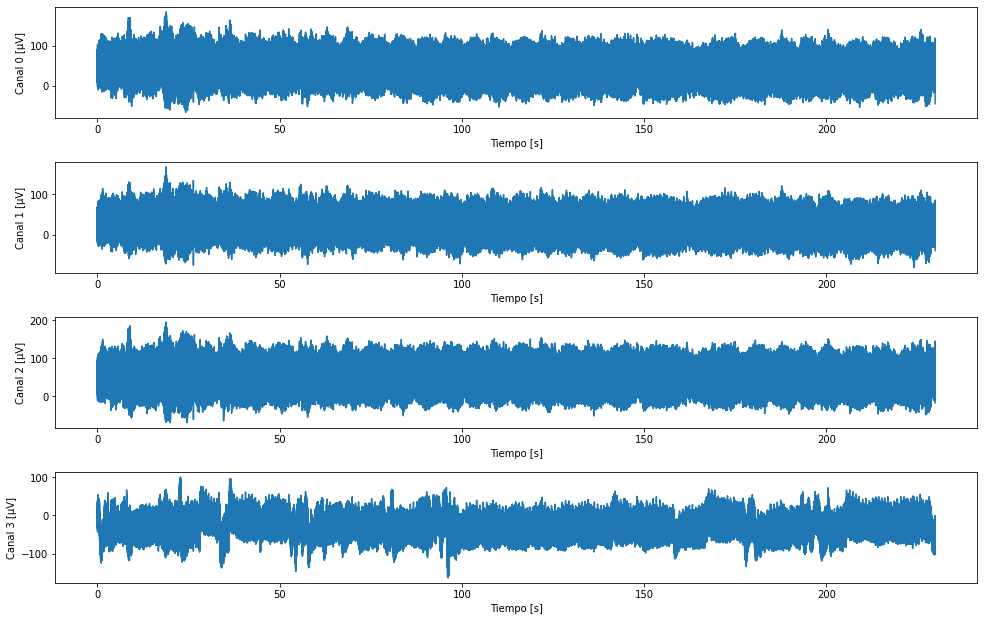

In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=(16, 10))
for i in range(4):
  fig =seaborn.lineplot(data = df_AA0, x="time",y=f"ch{i}",ax=axes[i])
  fig.set_xlabel("Tiempo [s]")
  fig.set_ylabel(f"Canal {i} [µV]")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

### I D) 2. Un mismo canal - todos los sujetos

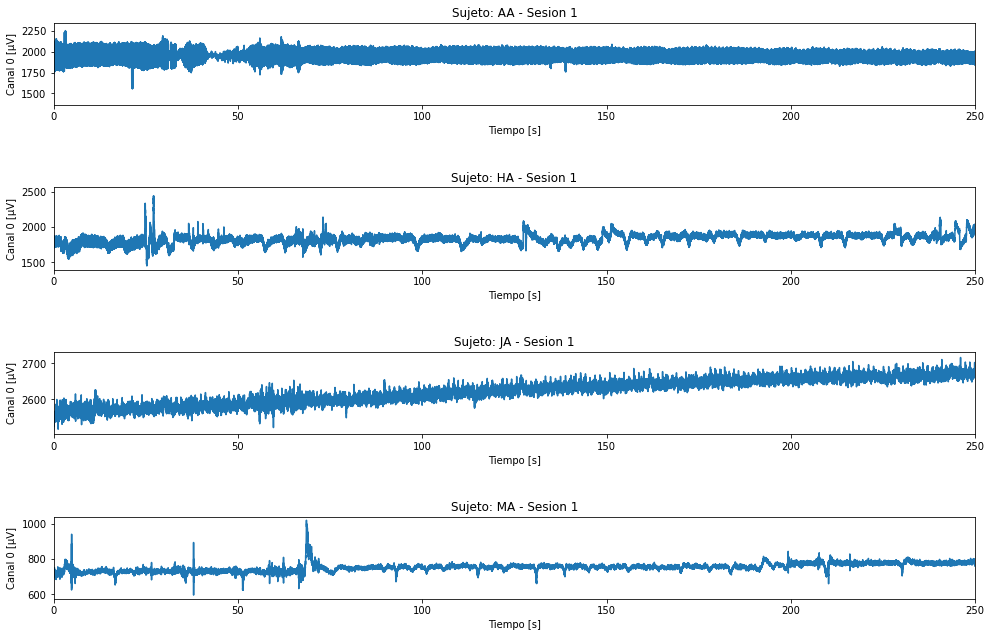

In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=(16, 10))
dataframes = [(df_AA1,"AA"),(df_HA1,"HA"),(df_JA1,"JA"),(df_MA1,"MA")]
for i in range(4):
  fig =seaborn.lineplot(data = dataframes[i][0], x="time",y=f"ch0",ax=axes[i])
  fig.set_xlabel("Tiempo [s]")
  fig.set_ylabel("Canal 0 [µV]")
  fig.set_title(f"Sujeto: {dataframes[i][1]} - Sesion 1")
  fig.set(xlim=(0, 250))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)


### I D) 3. Un mismo canal - mismo sujeto en diferentes sesiones.

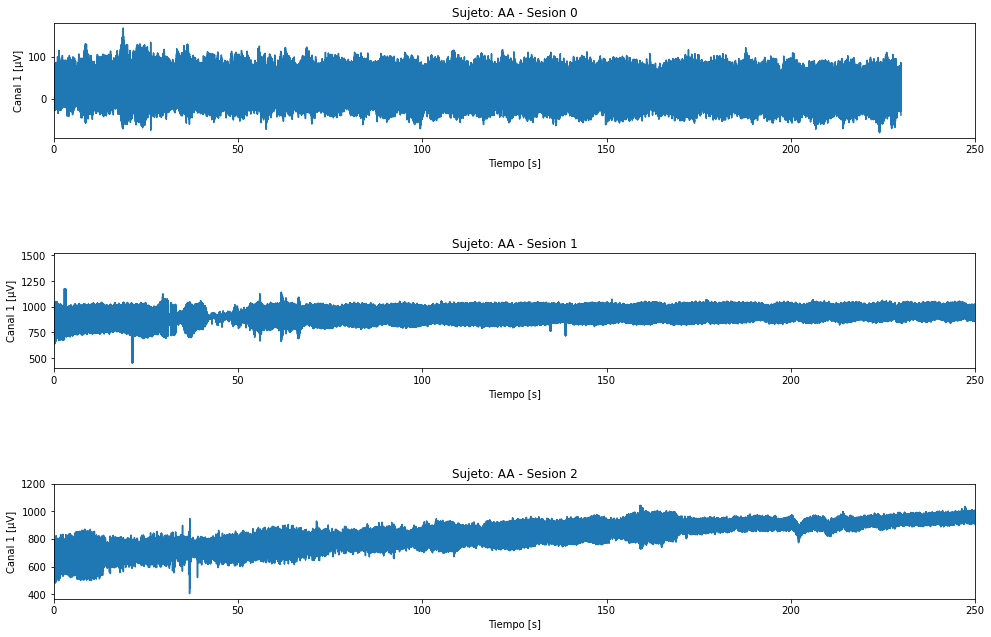

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 10))
dataframes = [df_AA0,df_AA1,df_AA2]
for i in range(3):
  fig =seaborn.lineplot(data = dataframes[i], x="time",y="ch1",ax=axes[i])
  fig.set_xlabel("Tiempo [s]")
  fig.set_ylabel("Canal 1 [µV]")
  fig.set_title(f"Sujeto: AA - Sesion {i}")
  fig.set(xlim=(0, 250))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)


### I D) 4. Un mismo sujeto y canal - diferentes estados

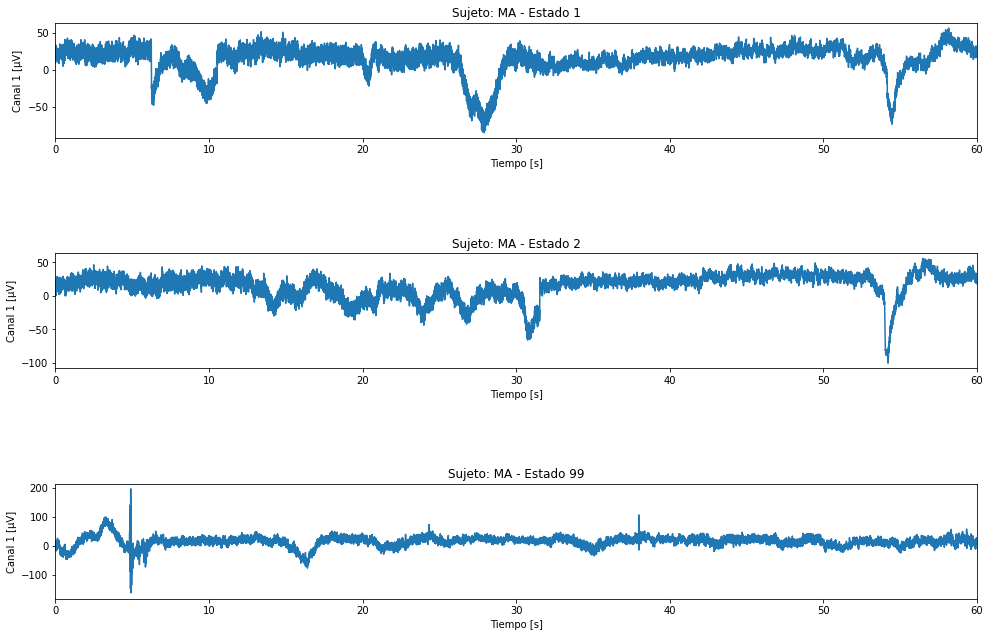

In [ ]:
def label_time(dataframe,label):
  result = dataframe[dataframe.label==label]
  result = result.drop(['time'], axis=1)
  result = result.copy()
  result = result.reset_index()
  result['time'] = result.index.values/200
  return result

df_MA1_1 = label_time(df_MA1,1)
df_MA1_2 = label_time(df_MA1,2)
df_MA1_99 = label_time(df_MA1,99)

fig, axes = plt.subplots(nrows=3, figsize=(16, 10))
dataframes = [(df_MA1_1,1),(df_MA1_2,2),(df_MA1_99,99)]
for i in range(3):
  fig =seaborn.lineplot(data = dataframes[i][0], x="time",y="ch1",ax=axes[i])
  fig.set_xlabel("Tiempo [s]")
  fig.set_ylabel("Canal 1 [µV]")
  fig.set_title(f"Sujeto: MA - Estado {dataframes[i][1]}")
  fig.set(xlim=(0, 60))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)


### I D) 5. Mismo estado - diferentes sujetos

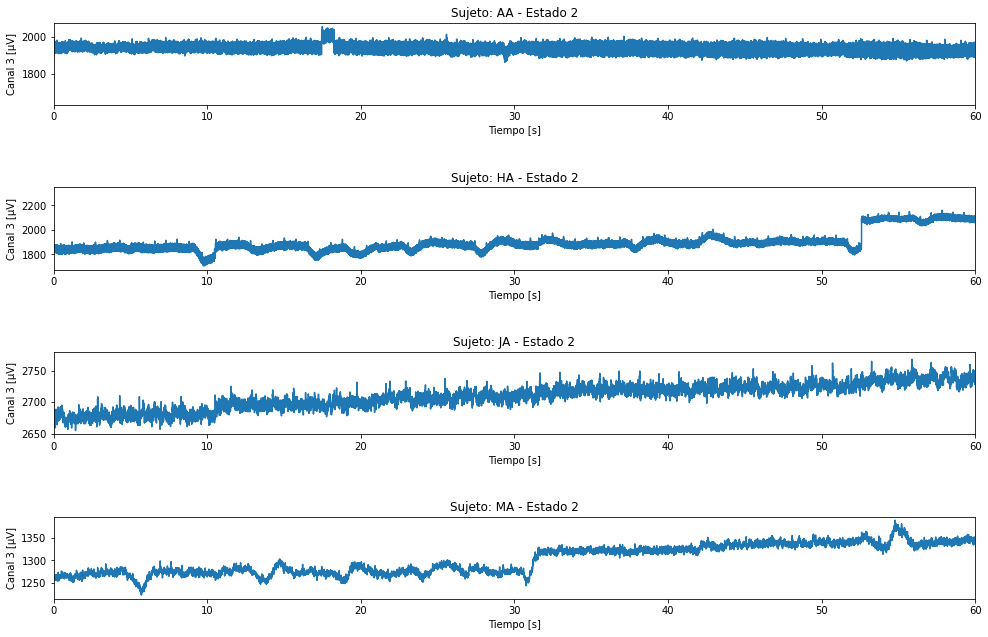

In [ ]:
df_AA1_2 = label_time(df_AA1,2)
df_HA1_2 = label_time(df_HA1,2)
df_JA1_2 = label_time(df_JA1,2)
df_MA1_2 = label_time(df_MA1,2)

fig, axes = plt.subplots(nrows=4, figsize=(16, 10))
dataframes = [(df_AA1_2,"AA"),( df_HA1_2, "HA"), (df_JA1_2, "JA"),(df_MA1_2,"MA")]
for i in range(4):
  fig =seaborn.lineplot(data = dataframes[i][0], x="time",y="ch3",ax=axes[i])
  fig.set_xlabel("Tiempo [s]")
  fig.set_ylabel("Canal 3 [µV]")
  fig.set_title(f"Sujeto: {dataframes[i][1]} - Estado 2")
  fig.set(xlim=(0, 60))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)

###¿Extrae alguna información que considere relevante para el problema? ¿Se observa algún fenómeno distinguible a primera vista?

Lo primero que se observa es que el volaje medido por los canales tiende a subir con el paso del tiempo mas alla del comportamiento caracteristico de cada canal o estado. Esto podria deberse a errores sistematicos en la medicion o a una descalibracion del sensor.
No se observo correlacion entre distintos sujetos, distintas sesiones o entre distintos estados. La unica correlacion observada fue para un mismo sujeto y una misma sesion entre los canales 0,1 y 2 que parecian presentar respuestas similares a diferencia del canal 3. 

#Parte II: Dominio del tiempo.


##II A) Nivel Segmento/Estado: Seleccione los datos correspondientes a un paciente y un canal, y para él defina un conjunto de señales para cada estado presente en el dataset. Para cada uno de ellos estudie los siguientes elementos y luego compárelos.


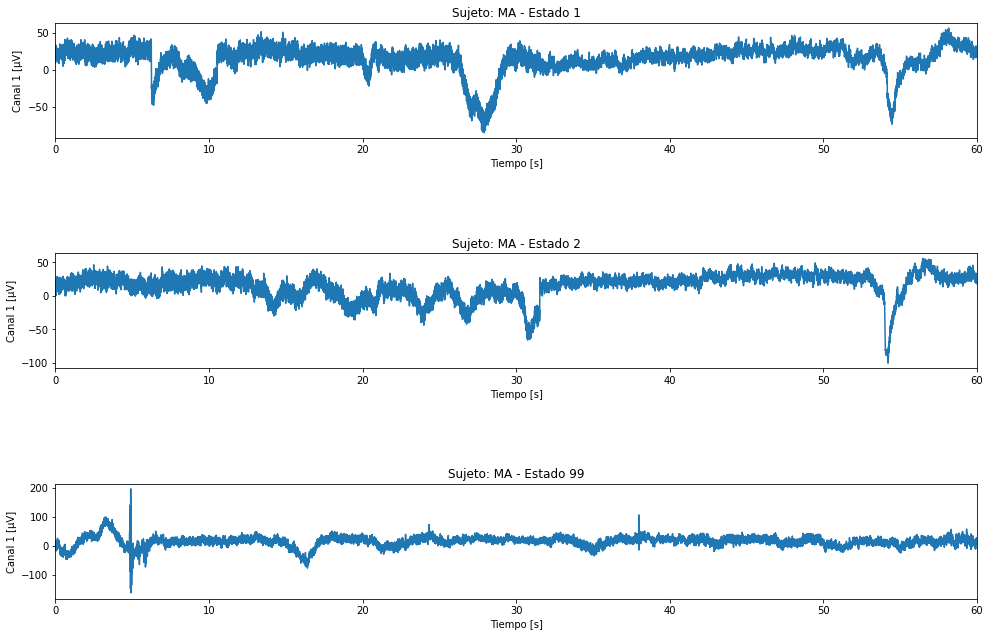

In [ ]:
def label_time(dataframe,label):
  result = dataframe[dataframe.label==label]
  result = result.drop(['time'], axis=1)
  result = result.copy()
  result = result.reset_index()
  result['time'] = result.index.values/200
  return result

df_MA1_1 = label_time(df_MA1,1)
df_MA1_2 = label_time(df_MA1,2)
df_MA1_99 = label_time(df_MA1,99)

fig, axes = plt.subplots(nrows=3, figsize=(16, 10))
dataframes = [(df_MA1_1,1),(df_MA1_2,2),(df_MA1_99,99)]
for i in range(3):
  fig =seaborn.lineplot(data = dataframes[i][0], x="time",y="ch1",ax=axes[i])
  fig.set_xlabel("Tiempo [s]")
  fig.set_ylabel("Canal 1 [µV]")
  fig.set_title(f"Sujeto: MA - Estado {dataframes[i][1]}")
  fig.set(xlim=(0, 60))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)


Este bloque de codigo selecciona para un mismo sujeto en una misma sesion, los diferentes estados observados y reinicia el conteo temporal.

### II A a) ¿Presenta los valores de voltaje una distribución normal? Utilizar un criterio gráfico y un test para probarlo. Si la distribución normal no se ajusta, ¿a qué distribución se asemejan?


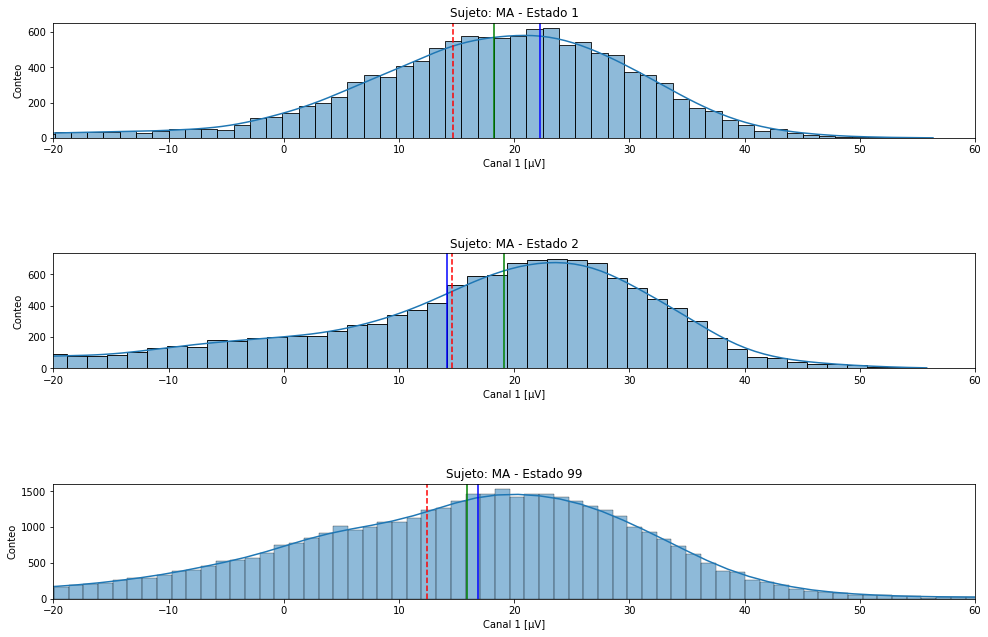

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 10))
dataframes = [(df_MA1_1,1),(df_MA1_2,2),(df_MA1_99,99)]
for i in range(3):
  #fig = seaborn.lineplot(data = , x="time",y="ch1",ax=axes[i])
  fig = seaborn.histplot(data= dataframes[i][0], x="ch1",ax=axes[i], kde=True)
  #fig = sns.displot(dataframes[i][0].ch1)
  fig.set_xlabel("Canal 1 [µV]")
  fig.set_ylabel("Conteo")
  fig.set_title(f"Sujeto: MA - Estado {dataframes[i][1]}")
  fig.set(xlim=(-20, 60))
  mean=dataframes[i][0].ch1.mean()
  median=dataframes[i][0].ch1.median()
  mode=dataframes[i][0].ch1.mode()[0]
  axes[i].axvline(mean, color='r', linestyle='--')
  axes[i].axvline(median, color='g', linestyle='-')
  axes[i].axvline(mode, color='b', linestyle='-')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)

In [ ]:
#aca iria el test de hipotesis, hay que usar la funcion definida por el histograma
#from scipy import stats

#k2, p = stats.normaltest(x)

from numpy.random import seed, randn
import matplotlib.pyplot as plt
from scipy.stats import normaltest
# Configuro la semilla aleatoria
seed(1993)
# Genero 100 muestras
data = randn(100)
# Test de DAgostino
dataframes = [(df_MA1_1,1),(df_MA1_2,2),(df_MA1_99,99)]
for i in range(3):
    stat, p = normaltest(dataframes[i][0].ch1)
    print('Estadisticos=%.3f, p=%.3f' % (stat, p))
# Interpretación
    alpha = 0.05
    if p > alpha:
       print(f'La distribución del estado {dataframes[i][1]} parece Gaussiana o Normal (no se rechaza la hipótesis nula H0)')
    else:
       print(f'La distribución del estado {dataframes[i][1]} no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)')



Estadisticos=5190.556, p=0.000
La distribución del estado 1 no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)
Estadisticos=3920.412, p=0.000
La distribución del estado 2 no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)
Estadisticos=13396.731, p=0.000
La distribución del estado 99 no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)


Las distribuciones no coinciden con normales.

Los resultados observados podrian describirse por una distribución polimodal, esto es, una conjunción de distribuciones normales, cada una con su propia media y varianza. 

Para explicar las colas largas que vemos hacia la izquierda en cada gráfico, podriamos suponer una distribución dada por

$∑_{i=1}^n I_iN(μ_i,σ_i)$

donde 

$ I_i < I_j $, $μ_i < μ_j$  $∀ i < j $

### II A b) Realice un resumen estadístico de los valores de voltaje en el intervalo de tiempo considerado. ¿Qué estimador de posición central usaría para describir los valores? ¿Y de dispersión?


In [ ]:
dataframes = [(df_MA1_1,1),(df_MA1_2,2),(df_MA1_99,99)]
for df in dataframes:
  print(f"Estado:{df[1]}")
  print(f"Moda: {df[0].ch1.mode()[0]}")
  print(f"Mediana: {df[0].ch1.median()}")
  print(f"Media: {df[0].ch1.mean()}")
  print(f"Desviacion estandar: {df[0].ch1.std()}")
  print()

Estado:1
Moda: 22.27
Mediana: 18.255000000000003
Media: 14.649522565320668
Desviacion estandar: 18.965103109621968

Estado:2
Moda: 14.16
Mediana: 19.14
Media: 14.621739130434783
Desviacion estandar: 19.0844521336926

Estado:99
Moda: 16.89
Mediana: 15.94
Media: 12.386609452680357
Desviacion estandar: 21.858617885632157



Para la posicion central usariamos la media, y para dispersion la desviacion estandar.

In [ ]:
dataframes = [(df_MA1_1,1),(df_MA1_2,2),(df_MA1_99,99)]
for df in dataframes:
  print(f"Estado:{df[1]}")
  print(df[0].ch1.describe())
  print()

Estado:1
count    12630.000000
mean        14.649523
std         18.965103
min        -84.840000
25%          9.340000
50%         18.255000
75%         25.920000
max         56.350000
Name: ch1, dtype: float64

Estado:2
count    12627.000000
mean        14.621739
std         19.084452
min       -100.370000
25%          6.735000
50%         19.140000
75%         27.150000
max         55.800000
Name: ch1, dtype: float64

Estado:99
count    44453.000000
mean        12.386609
std         21.858618
min       -165.470000
25%          3.100000
50%         15.940000
75%         25.710000
max        197.020000
Name: ch1, dtype: float64



### II A c) En adición a los datos dañados encontrados en la parte I, ¿Encuentra outliers a este nivel de análisis? ¿Estos outliers deberían ser tratados de forma diferencial? ¿De qué manera?


No se encontraron datos dañados ni outliers.

### II A d) ¿Existe una diferencia estadísticamente significativa para considerar que los estimadores de posición central son diferentes entre los estados? Use un test de hipótesis para probarlo al menos entre dos estados.


In [ ]:

mu_1  = df_MA1_1.ch1.mean()
mu_2  = df_MA1_2.ch1.mean()
mu_99 = df_MA1_99.ch1.mean()

print((mu_1,mu_2,mu_99))

var_1  = df_MA1_1.ch1.var()
var_2  = df_MA1_2.ch1.var()
var_99 = df_MA1_99.ch1.var()

print((var_1,var_2,var_99))

n_1  = len(df_MA1_1.ch1)
n_2  = len(df_MA1_2.ch1)
n_99 = len(df_MA1_99.ch1)

print((n_1,n_2,n_99))

t_12  = (mu_1 - mu_2 ) / np.sqrt( var_1/n_1 + var_2 /n_2  )
t_199 = (mu_1 - mu_99) / np.sqrt( var_1/n_1 + var_99/n_99 )
t_299 = (mu_2 - mu_99) / np.sqrt( var_2/n_2 + var_99/n_99 )

print((t_12,t_199,t_299))

(14.649522565320668, 14.621739130434783, 12.386609452680357)
(359.6751359585928, 364.21631324320407, 477.799175870078)
(12630, 12627, 44453)
(0.1160445992181619, 11.425611753580666, 11.23299034148559)


Las distribuciones para los estados 1 y 2, correspondientes a estar recibiendo un estímulo específico, son indistinguibles estadísticamente. Por otro lado, vemos diferencias estadísticas significativas entre los estados estimulados y el no estimulado, lo que es de esperarse.

### II A e) Resuma las principales conclusiones de este nivel de análisis.


Las distribuciones observadas no concuendan con normales, pero podrian describirse por distribuciones polimodales. 

Para estimar correctamente la posición central y la dispersión de los valores observados del voltaje, recomendamos emplear la media y la desviación eswtándar respectivamente.

No se encontraron outliers ni datos dañados en este análisis.

Las distribuciones para los estados 1 y 2, correspondientes a estar recibiendo un estímulo específico, son indistinguibles estadísticamente. Por otro lado, vemos diferencias estadísticas significativas entre los estados estimulados y el no estimulado, lo que es de esperarse.

## II B) Nivel Paciente - un canal: Seleccione los datos correspondientes a un paciente y un canal de adquisición y para ese caso estudie los siguientes elementos:


In [ ]:
#Selección un paciente un canal

df_HA1.ch1

0          771.75
1          706.07
2          806.13
3          840.87
4          753.03
           ...   
137688    1176.88
137689    1168.73
137690    1152.47
137691    1159.43
137692    1177.42
Name: ch1, Length: 137693, dtype: float64

### II B a) Considere el conjunto completo de valores de voltaje correspondientes a cada uno de los estados a lo largo de todo el registro y repita los elementos del apartado II-A).


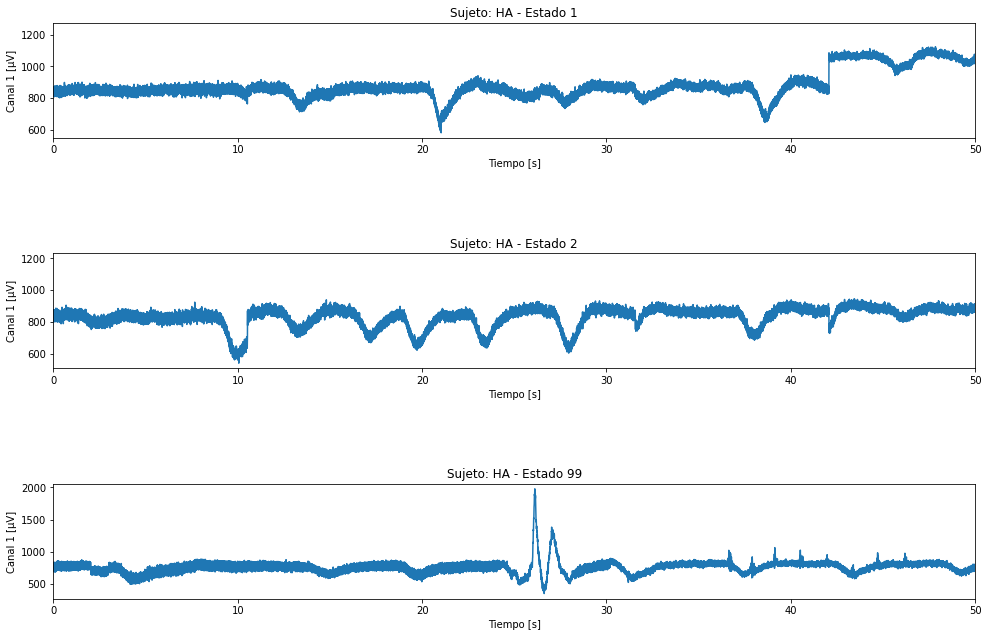

In [ ]:
df_HA1_1 = label_time(df_HA1,1)
df_HA1_2 = label_time(df_HA1,2)
df_HA1_99 = label_time(df_HA1,99)

fig, axes = plt.subplots(nrows=3, figsize=(16, 10))
dataframes = [(df_HA1_1,1),(df_HA1_2,2),(df_HA1_99,99)]
for i in range(3):
  fig =seaborn.lineplot(data = dataframes[i][0], x="time",y="ch1",ax=axes[i])
  fig.set_xlabel("Tiempo [s]")
  fig.set_ylabel("Canal 1 [µV]")
  fig.set_title(f"Sujeto: HA - Estado {dataframes[i][1]}")
  fig.set(xlim=(0, 50))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)

#### II B a) a) Presentan los valores de voltaje una distribución normal?

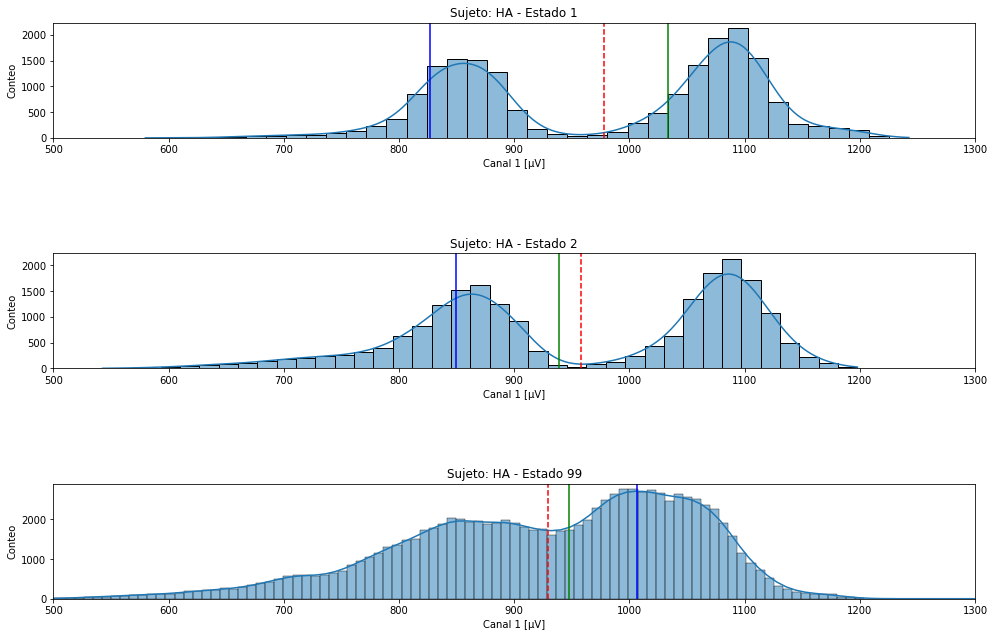

In [ ]:
fig, axes = plt.subplots(nrows=3, figsize=(16, 10))
dataframes = [(df_HA1_1,1),(df_HA1_2,2),(df_HA1_99,99)]
for i in range(3):
  #fig = seaborn.lineplot(data = , x="time",y="ch1",ax=axes[i])
  fig = seaborn.histplot(data= dataframes[i][0], x="ch1",ax=axes[i], kde=True)
  #fig = sns.displot(dataframes[i][0].ch1)
  fig.set_xlabel("Canal 1 [µV]")
  fig.set_ylabel("Conteo")
  fig.set_title(f"Sujeto: HA - Estado {dataframes[i][1]}")
  fig.set(xlim=(500, 1300))
  mean=dataframes[i][0].ch1.mean()
  median=dataframes[i][0].ch1.median()
  mode=dataframes[i][0].ch1.mode()[0]
  axes[i].axvline(mean, color='r', linestyle='--')
  axes[i].axvline(median, color='g', linestyle='-')
  axes[i].axvline(mode, color='b', linestyle='-')

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=1)

In [ ]:
dataframes = [(df_HA1_1,1),(df_HA1_2,2),(df_HA1_99,99)]
for i in range(3):
    stat, p = normaltest(dataframes[i][0].ch1)
    print('Estadisticos=%.3f, p=%.3f' % (stat, p))
# Interpretación
    alpha = 0.05
    if p > alpha:
       print(f'La distribución del estado {dataframes[i][1]} parece Gaussiana o Normal (no se rechaza la hipótesis nula H0)')
    else:
       print(f'La distribución del estado {dataframes[i][1]} no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)')

Estadisticos=309150.275, p=0.000
La distribución del estado 1 no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)
Estadisticos=9510.226, p=0.000
La distribución del estado 2 no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)
Estadisticos=3782.608, p=0.000
La distribución del estado 99 no parece Gaussiana o Normal(se rechaza la hipótesis nula H0)


Las distribuciones observadas parecen ser bimodales, es decir, suma de dos distribuciones normales, por lo que no encajan con una distribución normal estandar.

#### II B a) b) Realice un resumen estadístico de los valores de voltaje en el intervalo de tiempo considerado. ¿Qué estimador de posición central usaría para describir los valores? ¿Y de dispersión?

In [ ]:
dataframes = [(df_HA1_1,1),(df_HA1_2,2),(df_HA1_99,99)]
for df in dataframes:
  print(f"Estado:{df[1]}")
  print(df[0].ch1.describe())
  print()

Estado:1
count    18936.000000
mean       978.333050
std        126.687706
min        579.740000
25%        857.132500
50%       1033.420000
75%       1090.090000
max       1242.560000
Name: ch1, dtype: float64

Estado:2
count    21029.000000
mean       957.760112
std        134.828109
min        542.560000
25%        850.390000
50%        939.000000
75%       1084.240000
max       1197.930000
Name: ch1, dtype: float64

Estado:99
count    97728.000000
mean       929.462942
std        123.294959
min        352.980000
25%        844.450000
50%        947.860000
75%       1026.570000
max       1976.220000
Name: ch1, dtype: float64



La posición central de la distribución se estima por la media, mientras que la disperción se estima por la desviación estandar.

#### II B a) c) En adición a los datos dañados encontrados en la parte I, ¿Encuentra outliers a este nivel de análisis? ¿Estos outliers deberían ser tratados de forma diferencial? ¿De qué manera?

No encontramos outliers o datos dañados a este nivel de análisis.

#### II B a) d) ¿Existe una diferencia estadísticamente significativa para considerar que los estimadores de posición central son diferentes entre los estados? Use un test de hipótesis para probarlo al menos entre dos estados.

In [ ]:
mu_1  = df_HA1_1.ch1.mean()
mu_2  = df_HA1_2.ch1.mean()
mu_99 = df_HA1_99.ch1.mean()

print((mu_1,mu_2,mu_99))

var_1  = df_HA1_1.ch1.var()
var_2  = df_HA1_2.ch1.var()
var_99 = df_HA1_99.ch1.var()

print((var_1,var_2,var_99))

n_1  = len(df_HA1_1.ch1)
n_2  = len(df_HA1_2.ch1)
n_99 = len(df_HA1_99.ch1)

print((n_1,n_2,n_99))

t_12  = (mu_1 - mu_2 ) / np.sqrt( var_1/n_1 + var_2 /n_2  )
t_199 = (mu_1 - mu_99) / np.sqrt( var_1/n_1 + var_99/n_99 )
t_299 = (mu_2 - mu_99) / np.sqrt( var_2/n_2 + var_99/n_99 )

print((t_12,t_199,t_299))

(978.3330502746093, 957.7601117504399, 929.4629418385723)
(16049.774843877272, 18178.619097633506, 15201.646870600976)
(18936, 21029, 97728)
(15.72316745792667, 48.79379178316621, 28.01829998216923)


Según los estimadores estadísticos, los tres estados difieren notablemente desde un punto de vista estadístico.

#### II B a) e) Resuma las principales conclusiones de este nivel de análisis.

Los valores de voltaje observados presentan una distribución bimodal o multinomial, de modo que no encajan con distribuciones normales estandar.

Para describir la posición central y la dispersión de las distribuciones de voltajes se deben emplear la media y la desviación estándar respectivamente.

No se encontraron datos dañados ni outliers durante este análisis.

Los test de hipótesis señalan que existen diferencias estadísticas significativas entre los valores de voltaje registrados en cada uno de los estados.

### II B b) Ahora que dispone de más datos, ¿son variables independientes el estado registrado de la señal y su voltaje? Use herramientas cuantitativas y cualitativas para justificar su respuesta.


In [ ]:
#df_AA0 = clean_read_bci_csv('AA 0 - 2020-10-28.csv')
#df_AA1 = clean_read_bci_csv('AA 1 - 2020-11-24.txt')
#df_AA2 = clean_read_bci_csv('AA 2 - 2020-11-24.txt')
#df_HA1 = clean_read_bci_csv('HA 1 - 2020-11-24.txt')
#df_JA1 = clean_read_bci_csv('JA 1 - 2020-11-19.txt')
#df_JA2 = clean_read_bci_csv('JA 2 - 2020-11-24.txt')
#df_MA1 = clean_read_bci_csv('MA 1 - 2020-12-18.txt')

<AxesSubplot:xlabel='VoltMed', ylabel='Est'>

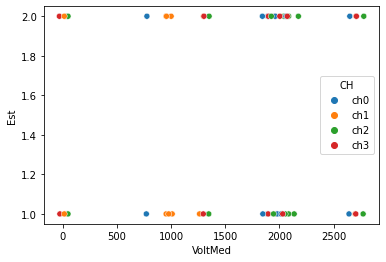

In [ ]:
dataframes = [df_AA0 ,df_AA1, df_AA2, df_HA1, df_JA1, df_JA2, df_MA1]
chanels = ['ch0', 'ch1', 'ch2', 'ch3']
estados = [1, 2]#, 99]

VpE = []

for df in dataframes:
  for ch in chanels:
    for es in estados:
      VpE.append(  [df[df.label==es][ch].mean() ,es,ch]  )
VpE = pd.DataFrame(VpE)
VpE.columns = ['VoltMed', 'Est', 'CH']

seaborn.scatterplot(data=VpE,
                    x='VoltMed',
                    y='Est', 
                    hue='CH')


No vemos correlación alguna entre el estado registrado de la señal y el voltaje medio encontrado para el mismo, con lo que podemos concluir que son variables independientes. 

### II B c) Para cada uno de los estados, los valores de voltaje a lo largo del tiempo, ¿varían con alguna tendencia?


Si, en distintos gráficos hemos observado que el valor medio del voltaje tiende a crecer a lo largo del tiempo. Esto podría deberse a un error sistemático en la medición tal como una descalibración de los intrumentos. 

### II B d) Resuma las principales conclusiones de este nivel de análisis.


Los valores de voltaje observados presentan una distribución bimodal o multinomial, de modo que no encajan con distribuciones normales estandar.
Para describir la posición central y la dispersión de las distribuciones de voltajes se deben emplear la media y la desviación estándar respectivamente.
No se encontraron datos dañados ni outliers durante este análisis.
Los test de hipótesis señalan que existen diferencias estadísticas significativas entre los valores de voltaje registrados en cada uno de los estados.

No encontramos correlación alguna entre el estado del paciente y el voltaje medio observado.

Se observó que el valor medio del voltaje tiende a incrementarse con el tiempo.

## II C) Nivel Paciente - multicanal: Seleccione los datos correspondientes a un paciente y para ese caso estudie los siguientes elementos:


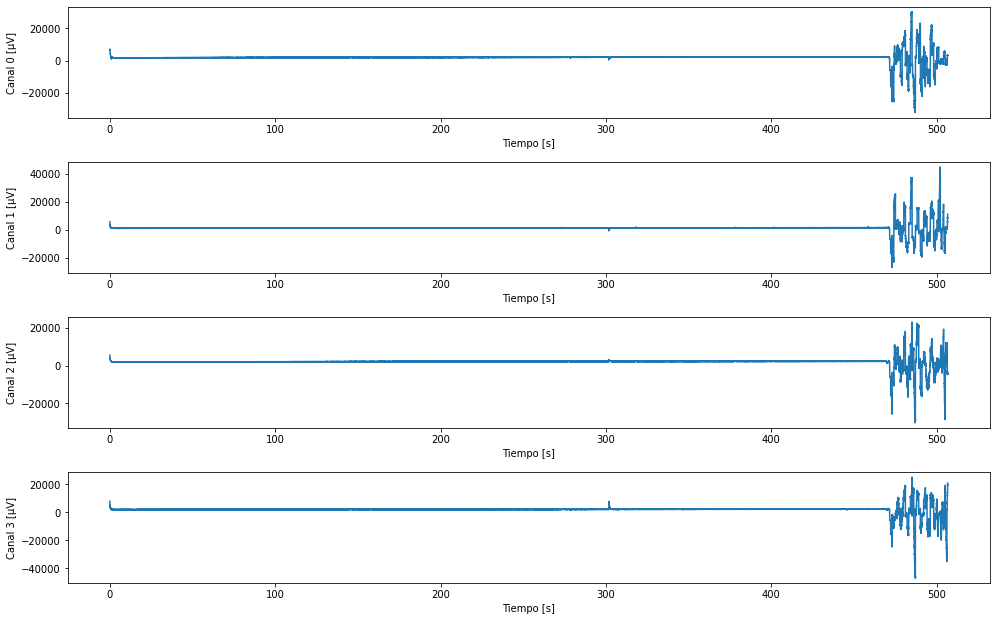

In [ ]:
fig, axes = plt.subplots(nrows=4, figsize=(16, 10))
for i in range(4):
  fig =seaborn.lineplot(data = df_JA2, x="time",y=f"ch{i}",ax=axes[i])
  fig.set_xlabel("Tiempo [s]")
  fig.set_ylabel(f"Canal {i} [µV]")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)

### II C a) Las señales de voltaje en función del tiempo para cada canal, ¿son variables independientes entre sí? Use herramientas cuantitativas y cualitativas para justificar su respuesta. (Ejemplo, matriz de correlación)


In [ ]:
df_JA2.corr()

,ch0,ch1,ch2,ch3,label,time
ch0,1.000000,0.697382,0.707426,0.724572,-0.061210,-0.068912
ch1,0.697382,1.000000,0.651908,0.517900,-0.011017,0.017532
ch2,0.707426,0.651908,1.000000,0.600690,-0.062654,-0.071456
ch3,0.724572,0.517900,0.600690,1.000000,-0.071918,-0.103816
label,-0.061210,-0.011017,-0.062654,-0.071918,1.000000,-0.032238
time,-0.068912,0.017532,-0.071456,-0.103816,-0.032238,1.000000


Podemos ver que las señales de voltaje en función del tiempo para cada canal estan altamente correlacionadas, según se muestra en la matriz de correlación anterior.

### II C b) Tomando los puntos que considere relevantes del apartado II-B) para cada canal y considerando la respuesta anterior. ¿Considera relevante trabajar con todos los canales disponibles o podría quedarse con un subconjunto? Si elige el subconjunto, ¿qué canales elegiría y por qué?


In [ ]:
dataframes = [df_AA0 ,df_AA1, df_AA2, df_HA1, df_JA1, df_JA2, df_MA1]

for df in dataframes:
  print(df.corr())

            ch0       ch1       ch2       ch3     label      time
ch0    1.000000  0.981442  0.988626  0.849224  0.069203 -0.092560
ch1    0.981442  1.000000  0.985798  0.868610  0.061513 -0.091361
ch2    0.988626  0.985798  1.000000  0.860538  0.035216 -0.037114
ch3    0.849224  0.868610  0.860538  1.000000  0.031371 -0.000916
label  0.069203  0.061513  0.035216  0.031371  1.000000 -0.398047
time  -0.092560 -0.091361 -0.037114 -0.000916 -0.398047  1.000000
            ch0       ch1       ch2       ch3     label      time
ch0    1.000000  0.587315  0.808805  0.375864  0.024025 -0.614953
ch1    0.587315  1.000000  0.903763 -0.203183 -0.012153  0.260103
ch2    0.808805  0.903763  1.000000 -0.138677  0.003034 -0.097328
ch3    0.375864 -0.203183 -0.138677  1.000000  0.049591 -0.611170
label  0.024025 -0.012153  0.003034  0.049591  1.000000 -0.071941
time  -0.614953  0.260103 -0.097328 -0.611170 -0.071941  1.000000
            ch0       ch1       ch2       ch3     label      time
ch0    1.0

In [ ]:
seaborn.jointplot

<function seaborn.axisgrid.jointplot(*, x=None, y=None, data=None, kind='scatter', color=None, height=6, ratio=5, space=0.2, dropna=False, xlim=None, ylim=None, marginal_ticks=False, joint_kws=None, marginal_kws=None, hue=None, palette=None, hue_order=None, hue_norm=None, **kwargs)>

Vemos que, en general, existe una fuerte correlación entre el voltaje registrado por todos los canales en función del tiempo para cada paciente y en cada sesión. En algunas sesiones en particular, puede observarse una menor correlación entre alguno  de los canales con el resto, pero esto varía de sesión en sesión y no parece arrojar resultados consistentes. 

Concluimos que todos los canales estan fuertemente correlacionados por lo que podemos quedarnos con solo uno de ellos y prescindir del resto.

### II C c) Opcional: Tomando un par de canales a elección, analice la distribución conjunta de los valores de voltaje para cada estado de forma cualitativa. (Ejemplo, Heatmap, scatterplot, 3D-mesh, etc.)


### II C d) Resuma las principales conclusiones de este nivel de análisis.


Las señales de voltaje en función del tiempo para cada canal estan altamente correlacionadas, por lo que no son variables independientes entre si y podriamos prescindir de la mayoría de ellas para el análisis, conservando solo una de ellas.

## II D) Nivel Multi-Paciente.


### II D a) A partir de las conclusiones extraídas de los niveles de análisis anteriores. Decida cuáles son los aspectos más importantes a analizar de los registros de un paciente y compárelos entre pacientes. ¿Encuentra diferencias significativas? ¿Qué variables pueden identificar esas diferencias? 

### A modo de ejemplo: los valores de voltaje medios para cada estado de un paciente, ¿difieren significativamente entre pacientes?

In [ ]:
dataframes = [(df_AA0, 'AA0'), (df_AA1, 'AA1'), (df_AA2, 'AA2'), (df_HA1, 'HA1'), (df_JA1, 'JA1'), (df_JA2, 'JA2'), (df_MA1, 'MA1')]
#estados[1,2,99]

for df, name in dataframes:
  print(name)
  print((df[df.label==1]['ch0'].mean(),df[df.label==2]['ch0'].mean(),df[df.label==99]['ch0'].mean()))
  print((df[df.label==1]['ch0'].std(),df[df.label==2]['ch0'].std(),df[df.label==99]['ch0'].std()))
  print()

AA0
(39.70890262121418, 41.10755468007064, 47.36764357034796)
(47.49518000634093, 47.544714713544586, 49.40405958926675)

AA1
(1889.6383938913127, 1891.6605067505764, 1895.0060343579205)
(87.28254184849523, 89.70507337138186, 86.59962687709348)

AA2
(1847.0156607859706, 1843.1282403576356, 1781.9943466098687)
(57.75914763119172, 52.18837159975078, 82.99838291033056)

HA1
(1981.8877439797209, 1960.8198064577484, 1938.8386903446296)
(120.81024256163704, 123.58007918729459, 113.77212540418374)

JA1
(2642.2331409342833, 2649.544375545159, 2613.2796747117795)
(25.899233924872217, 24.19768759434165, 38.280497308897104)

JA2
(2014.9944615465988, 2060.553827307326, 1663.7515844422367)
(122.29104099907018, 121.62553416793031, 3837.5436203656136)

MA1
(771.9767680126682, 777.2742694226658, 762.8479126268193)
(24.31600833257242, 26.614271079960993, 35.47909965029052)



Vemos que, en general, los valores medios de voltaje registrados para los estados 1 y 2 son significativamente similares, considerando sus desviaciones estandar, y difieren considerablemente del valor medio encontrado para el estado 99. No se encontro relación entre la diferencia de eswtos valores o sus magnitudes.

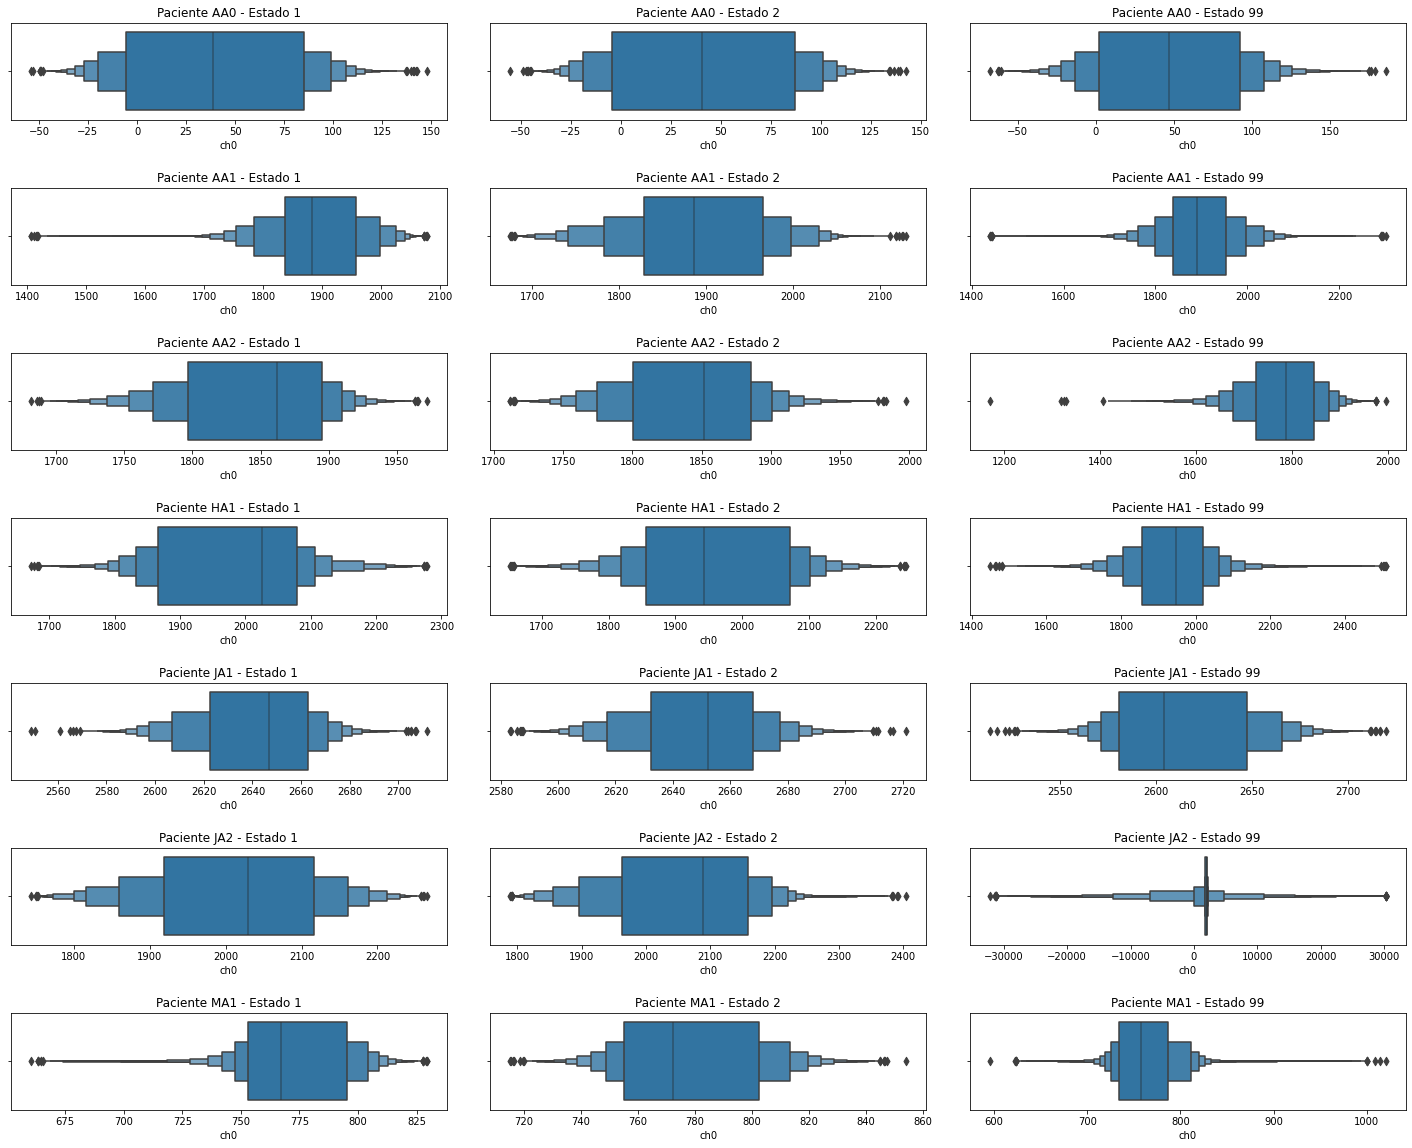

In [ ]:
def label_time(dataframe,label):
  result = dataframe[dataframe.label==label]
  result = result.drop(['time'], axis=1)
  result = result.copy()
  result = result.reset_index()
  result['time'] = result.index.values/200
  return result
dataframes = [(df_AA0, 'AA0'), (df_AA1, 'AA1'), (df_AA2, 'AA2'), (df_HA1, 'HA1'), (df_JA1, 'JA1'), (df_JA2, 'JA2'), (df_MA1, 'MA1')]
fig, axes = plt.subplots(ncols=3,nrows=len(dataframes), figsize=(25, 20))
plt.subplots_adjust(wspace=0.1,
                    hspace=0.7)
for (i,(df,name)) in enumerate(dataframes):
  for j,estado in enumerate([1,2,99]):
    a = seaborn.boxenplot(data=label_time(df,estado), x="ch0",ax=axes[i][j])
    a.set_title(f"Paciente {name} - Estado {estado}")